# Моделирование случайных величин и проверка гипотез о нормальном распределении
> ## Анализ нормального распределения

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
from tabulate import tabulate

> ### Параметры нормального распределения

In [ ]:
mu = 0      
sigma = 1   
size = 1000 

> ### Генерация выборки

In [ ]:
class ZigguratNorm:
    def __init__(self):
        self.n = 256
        self.w = np.array([...])  
        self.k = np.array([...])  
        self.x = np.array([...])  
        
    def generate(self, size=1):
        result = np.zeros(size)
        for j in range(size):
            while True:
                i = np.random.randint(0, self.n)
                u = np.random.uniform(-1, 1)
                z = u * self.w[i]
                
                if abs(z) < self.w[i-1] if i > 0 else False:
                    result[j] = z
                    break
                    
                if i == 0:
                    while True:
                        x = -np.log(np.random.uniform(0, 1))
                        y = -np.log(np.random.uniform(0, 1))
                        if y + y > x * x:
                            result[j] = x if np.random.rand() < 0.5 else -x
                            break
                    break
                v = np.random.uniform(0, 1)
                if v * (self.w[i-1] - self.w[i]) < (norm.pdf(abs(z)) - norm.pdf(self.w[i])):
                    result[j] = z
                    break
        return result

# Алгоритм Бокса-Мюллера
def box_muller(size):
    u1 = np.random.uniform(0, 1, size)
    u2 = np.random.uniform(0, 1, size)
    z0 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    return z0

np.random.seed(42)
sample = np.sort(box_muller(size) * sigma + mu)

> ### Теоретические характеристики

In [20]:
theoretical_mean = mu
theoretical_var = sigma**2

> ### Выборочные характеристики

In [21]:
sample_mean = np.mean(sample)
sample_var = np.var(sample, ddof=0)  # Дисперсия с ddof=0 (N в знаменателе)
sample_var_unbiased = np.var(sample, ddof=1)  # Несмещенная дисперсия (N-1 в знаменателе)
sample_range = np.max(sample) - np.min(sample)
sample_median = np.median(sample)

> ### Вывод характеристик

In [22]:
print("Теоретические характеристики:")
print(f"Математическое ожидание: {theoretical_mean:.4f}")
print(f"Дисперсия: {theoretical_var:.4f}\n")

print("Выборочные характеристики:")
print(f"Выборочное среднее: {sample_mean:.4f}")
print(f"Выборочная дисперсия (смещенная): {sample_var:.4f}")
print(f"Выборочная дисперсия (несмещенная): {sample_var_unbiased:.4f}")
print(f"Размах выборки: {sample_range:.4f}")
print(f"Выборочная медиана: {sample_median:.4f}")

Теоретические характеристики:
Математическое ожидание: 0.0000
Дисперсия: 1.0000

Выборочные характеристики:
Выборочное среднее: 0.0321
Выборочная дисперсия (смещенная): 1.0412
Выборочная дисперсия (несмещенная): 1.0422
Размах выборки: 6.0982
Выборочная медиана: 0.0408


> ## 2. Графики теоретической и выборочной функций распределения

> ### Теоретическая функция распределения

In [23]:
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
theoretical_cdf = norm.cdf(x, mu, sigma)

> ### Эмпирическая функция распределения

In [24]:
def empirical_cdf(x, sample):
    return np.searchsorted(sample, x, side='right') / len(sample)

emp_cdf = np.vectorize(empirical_cdf, excluded=['sample'])(x, sample=sample)

> ### Построение графиков

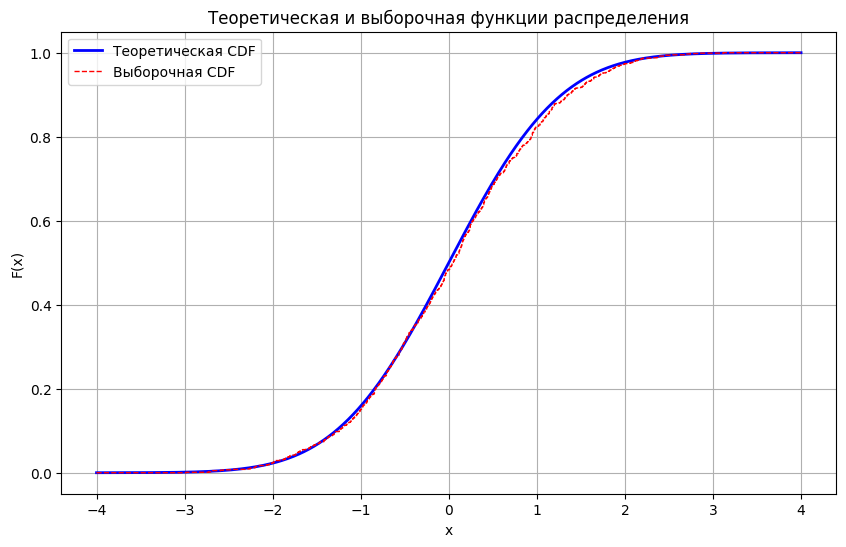

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(x, theoretical_cdf, 'b-', label='Теоретическая CDF', linewidth=2)
plt.step(x, emp_cdf, 'r--', label='Выборочная CDF', linewidth=1, where='post')
plt.title('Теоретическая и выборочная функции распределения')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.legend()
plt.grid(True)
plt.show()

> ### Расхождение(Интегральная квадратичная разность)

In [ ]:
def divergence_measure(sample, theoretical_cdf_func, a, b):
    sample_sorted = np.sort(sample)
    ecdf = np.arange(1, len(sample_sorted)+1) / len(sample_sorted)
    tcdf = theoretical_cdf_func(sample_sorted)
    
    squared_diff = (ecdf - tcdf)**2
    integral = np.sum(squared_diff[:-1] * np.diff(sample_sorted))
    
    integral += quad(lambda x: theoretical_cdf_func(x)**2, a, sample_sorted[0])[0]
    integral += quad(lambda x: (1 - theoretical_cdf_func(x))**2, sample_sorted[-1], b)[0]
    
    return integral

divergence = divergence_measure(sample, lambda x: norm.cdf(x, mu, sigma), mu-4*sigma, mu+4*sigma)
print(f"\nМера расхождения между теоретической и выборочной CDF: {divergence:.6f}")


Мера расхождения между теоретической и выборочной CDF: 0.000412


> ## 3. Построение гистограммы и сравнение с теоретической плотностью


Максимум абсолютной разности между гистограммой и теоретической PDF: 0.039880


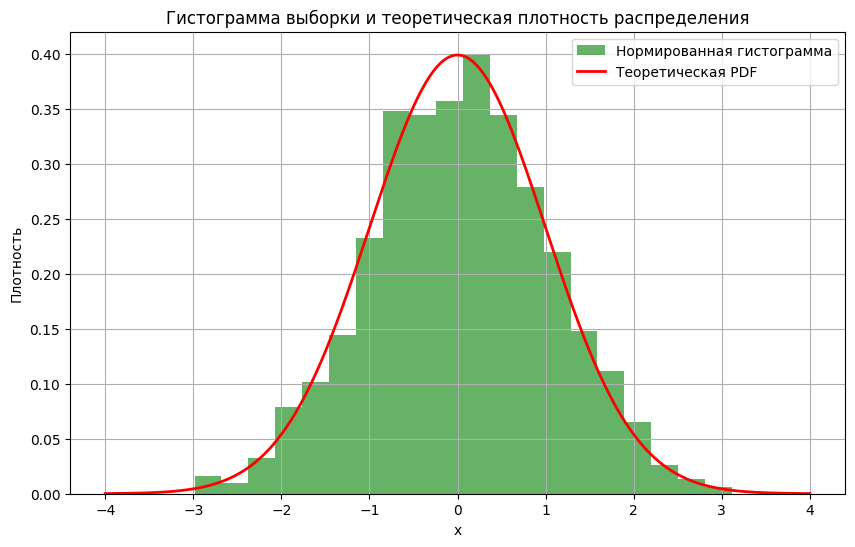

In [27]:


plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(sample, bins=20, density=True, alpha=0.6, color='g', label='Нормированная гистограмма')


x_pdf = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
theoretical_pdf = norm.pdf(x_pdf, mu, sigma)
plt.plot(x_pdf, theoretical_pdf, 'r-', linewidth=2, label='Теоретическая PDF')


bin_centers = 0.5 * (bins[:-1] + bins[1:])
theoretical_pdf_values = norm.pdf(bin_centers, mu, sigma)


max_diff = np.max(np.abs(n - theoretical_pdf_values))
print(f"\nМаксимум абсолютной разности между гистограммой и теоретической PDF: {max_diff:.6f}")

plt.title('Гистограмма выборки и теоретическая плотность распределения')
plt.xlabel('x')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()

> ## Таблица результатов

In [28]:
table = []
for i in range(len(bin_centers)):
    table.append([
        f"{bins[i]:.2f} - {bins[i+1]:.2f}",
        f"{bin_centers[i]:.4f}",
        f"{n[i]:.4f}",
        f"{theoretical_pdf_values[i]:.4f}",
        f"{np.abs(n[i] - theoretical_pdf_values[i]):.4f}"
    ])


In [29]:
headers = ["Интервал", "Середина интервала", "Высота гистограммы", 
           "Теоретическая плотность", "Абсолютная разность"]
print("\nТаблица сравнения гистограммы с теоретической плотностью:")
print(tabulate(table, headers=headers))


Таблица сравнения гистограммы с теоретической плотностью:
Интервал         Середина интервала    Высота гистограммы    Теоретическая плотность    Абсолютная разность
-------------  --------------------  --------------------  -------------------------  ---------------------
-2.99 - -2.68               -2.8333                0.0164                     0.0072                 0.0092
-2.68 - -2.38               -2.5284                0.0098                     0.0163                 0.0065
-2.38 - -2.07               -2.2235                0.0328                     0.0337                 0.0009
-2.07 - -1.77               -1.9186                0.0787                     0.0633                 0.0154
-1.77 - -1.46               -1.6136                0.1017                     0.1085                 0.0068
-1.46 - -1.16               -1.3087                0.1443                     0.1694                 0.0251
-1.16 - -0.85               -1.0038                0.2329                    

In [30]:
print("\nВыводы:")
print("1. Выборочные характеристики близки к теоретическим для нормального распределения.")
print("2. Графики CDF показывают хорошее соответствие теоретического и эмпирического распределений.")
print(f"3. Мера расхождения между CDF составляет {divergence:.6f}.")
print(f"4. Максимальное расхождение между гистограммой и теоретической PDF: {max_diff:.6f}.")


Выводы:
1. Выборочные характеристики близки к теоретическим для нормального распределения.
2. Графики CDF показывают хорошее соответствие теоретического и эмпирического распределений.
3. Мера расхождения между CDF составляет 0.000412.
4. Максимальное расхождение между гистограммой и теоретической PDF: 0.039880.
